<a href="https://colab.research.google.com/github/kimdain0222/deep_learning2/blob/main/14%EC%A3%BC%EC%B0%A8(%EA%B5%90%EC%88%98ver)CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Conv2D,Activation,MaxPooling2D,Flatten,Dense,BatchNormalization,Dropout

- `keras.models.Sequential`: `Sequential([layer1, layer2, ..])` 형태로 `layer`를 쌓아서 **ANN model**을 생성

- `Input(shape)`: ANN model의 입력 layer
> - `shape`은 하나의 입력 데이터 shape을 의미함 (즉, `X_train.shape`이 아닌 `X_train[0].shape`을 의미, **input layer node의 수를 결정**함)

- `Dense(units,activation)`: input layer를 제외한 일반적인 ANN의 **Hidden** 또는 **Output** layer 생성
> - `units`: node의 수 (output layer일 경우, 반드시 class의 수와 동일해야 함)
> - `activation`: 활성화 함수의 종류(`relu, sigmoid, tanh, softmax` 등), 생략 후, `Activation` layer로 대체할 수 있음

- `Conv2D(filters,kernel_size,strides,padding)`
> - `filters`: kernel의 수
> - `kernel_size`: kernel의 크기, 일반적으로 `(3,3)`으로 설정
> - `strides`: kernel의 이동 보폭 (default: `(1,1)`)
> - `padding`: `same`으로 설정할 경우, 출력(feature map)의 크기와 입력의 크기가 동일해짐 (default: `valid`, 출력의 크기가 작아짐)

- `MaxPooling2D(pool_size,strides,padding)`
> - `pool_size`: pool의 크기 (default: `(2,2)`)
> - `strides`: pool의 이동 보폭 (defalut: `None`, `pool_size`와 동일한 보폭이 설정됨)
> - `padding`: `Conv2D`와 동일

- `Flatten()`: 2D 이상의 결과(**image**)를 1D로 변경

- `Dropout(rate)`: **optional**, Overfitting을 방지하기 위해, `rate`의 비율만큼 임의의 node 값을 0으로 변경함
> - 일반적으로 복잡한 상호 관계가 있는 위치에서 `Dropout`을 적용함
> - **특징추출부**와 **분류부** 경계에서 가장 복잡한 상호관계가 있으므로, `Flatten`과 `Dense` 사이에 `Dropout`을 적용함
> - 여러 번의 특징 추출, `Conv2D`가 반복될 때, 첫번째와 두번째 특징추출 단계 사이에 `Dropout`을 적용함
> - `Conv2D` 대비, 분류부의 `Dense`와 `Dense` 사이에 아주 많은 가중치가 존재하므로, `Dense` 사이에 `Dropout` 적용

- `BatchNormalization()`: 앞선 layer의 출력분포가 크게 변화면, 뒤따르는 layer 변화하는 분포에 적응하면서 학습해야 하므로, 학습이 불안정해지고, 느려지는 현상을 방지하기 위해, **평균이 0, 표준펴차가 1인 분포로 변경**함
> - 분포를 변경함으로써 활성화 함수의 포화영역의 영향을 적게 받을 수 있음(이 효과를 위해서 `Conv2D` -> `BatchNormalization` -> `Activation` 순으로 구성함)
> - `Conv2D` 이후에 위치시키면 안정화된 분포의 feature map이 `Pooling`으로 전달되어, 더 안정적인 특징만 효과적으로 포착하여 다운샘플링 할 수 있음
> - `Pooling`은 단순히 최대값을 추출하는 단계이므로, 분포를 왜곡하지 않기 때문에, 일반적으로 `Pooling` layer 다음에는 두지 않음
> - 복잡한 상호관계가 있는 `Flatten`과 `Dense` 사이, 많은 가중치가 학습되는 `Dense`와 `Dense` 사이에도 `BatchNormalization`을 통해 분포를 안정화시키는 것이 좋음
> - `Dropout`과 함께 적용되는 경우, `Dropout`을 먼저 적용하면 통계 계산을 왜곡하고 불안정하게 할 수 있으므로, 반드시 `BatchNormalization` -> `Dropout` 순으로 구성함

- `np.load(file.npz)`: `npz` 파일을 로드한 후, `arr_0`, `arr_1` index를 통해 각 `ndarray`를 추출할 수 있음

In [ ]:
dataset = np.load('vehicle_data.npz')
X = dataset['arr_0']
y = dataset['arr_1']

- `X` 값을 **0-1** 범위로 scaling함

In [ ]:
X = X/255

In [ ]:
X.shape, y.shape

((500, 64, 64, 3), (500,))

- train/test data 분리

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

- `y`는 `str` type으로 저장되어 있으므로, `LabelEncoder` 또는 `OneHotEncoder`로 변환
> - `LabelEncoder`: loss -> **sparse_categorical_crossentropy**
> - `OneHotEncoder`: loss -> **categorical_crossentropy**

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train)

- **CNN structure**

In [ ]:
vehicle_model = Sequential([
    Input(shape=(64,64,3)), # shape: 한 개 image의 shape, (가로,세로,채널)
    #----- 특징 추출부
    Conv2D(filters=16,kernel_size=(3,3),strides=(1,1)),
    Activation('relu'),
    # Conv2D(....,activation='relu')와
    # Conv2D() -> Activation('relu')는 동일함
    MaxPooling2D(pool_size=(2,2),strides=(2,2)),
    Conv2D(filters=32,kernel_size=(3,3),strides=(1,1)),
    Activation('relu'),
    # 1d로 변환
    Flatten(),
    #----- 분류부
    Dropout(0.2),
    Dense(units=512,activation='relu'),
    # output layer node의 수는 class의 수와 일치
    # classification의 경우, 일반적으로 activation function을 softmax로 설정함
    Dense(units=2,activation='softmax')
])

In [ ]:
vehicle_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 62, 62, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 62, 62, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 29, 29, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 29, 29, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 26912)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 26912)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      13,779,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │           1,026 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,785,570 (52.59 MB)

 Trainable params: 13,785,570 (52.59 MB)

 Non-trainable params: 0 (0.00 B)

- learning model

In [ ]:
vehicle_model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['acc'])

- `ModelCheckpoint(filepath,save_weights_only,save_best_only,monitor,mode)`: 학습 과정에서 지정한 척도 기준으로 가장 성능이 좋은 모델을 저장할 수 있도록 함
> - `filepath`: checkpoint를 저장할 path
>> - weights만 저장할 경우 확장자: `.weights.h5`
>> - model을 저정할 경우 확장자: `.keras`
> - `save_weights_only`: True로 설정 시, weights만 저장
> - `save_best_only`: True로 설정 시, 최고 성능 모델만 저장
> - `monitor`: 성능 척도의 기준
> - `mode`: 최소/최대 설정

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(filepath='best.weights.h5',
                             save_weights_only=True,
                             save_best_only=True,
                             monitor='val_loss',
                             mode='min',
                             verbose=2)
# val_loss가 최소(min)가 되면, 해당 모델의 weights를 best.weights.h5에 업데이트하여 저장함

In [ ]:
train_result = vehicle_model.fit(X_train,y_train,
                                 validation_split=0.3,
                                 epochs=10,
                                 batch_size=32,
                                 callbacks=[checkpoint])

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - acc: 0.5365 - loss: 536.1876
Epoch 1: val_loss improved from inf to 81.02065, saving model to best.weights.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 427ms/step - acc: 0.5398 - loss: 521.7600 - val_acc: 0.6321 - val_loss: 81.0206
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - acc: 0.7756 - loss: 24.3467
Epoch 2: val_loss improved from 81.02065 to 1.36504, saving model to best.weights.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 401ms/step - acc: 0.7728 - loss: 23.3251 - val_acc: 0.8774 - val_loss: 1.3650
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - acc: 0.9894 - loss: 0.0818
Epoch 3: val_loss improved from 1.36504 to 0.99355, saving model to best.weights.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 400ms/step - acc: 0.9888 - loss: 0.0927 - val_acc: 0.9434 - val_loss: 0.9935
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - acc: 0.9922 - loss: 0.0153
Epoch 4: val_loss improved from 0.99355 to 0.87762, saving model to best.weights.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 

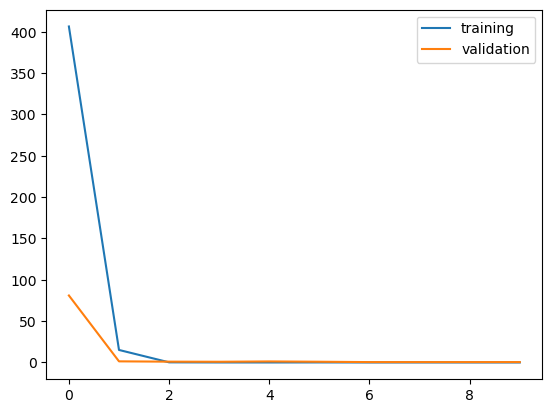

In [ ]:
plt.plot(train_result.history['loss'],label='training')
plt.plot(train_result.history['val_loss'],label='validation')
plt.legend()

- `X_test`를 이용한 성능 평가

In [ ]:
# y_test를 Label encoding함
y_test = le.transform(y_test)

In [ ]:
# ModelCheckpoint를 통해 저장된 최고 성능의 weight를 로드하지 않으면
# 학습이 종료된 시점의 모델을 사용함
vehicle_model.evaluate(X_test,y_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.9720 - loss: 0.1281 


[0.1979387104511261, 0.9666666388511658]

In [ ]:
# load_weights를 통해 최고 성능의 weight를 로드한 후, 성능 평가
vehicle_model.load_weights('best.weights.h5')
vehicle_model.evaluate(X_test,y_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.9772 - loss: 0.1208 


[0.18517185747623444, 0.9733333587646484]